This notebook shows how to use the general interface in HiGP for regression problems with a SciPy optimizer.

We will apply GP to a one-dimensional dataset $X$ randomly sampled from $[0, 1]$. The corresponding label is generated using a Gaussian Random Field. The data is stored in the file "Example00-EasyGPR.npz".

In this example, we use the Matern 3/2 kernel function in the form
$$
\mathcal{K}(x,y)=f^2 (1 + \sqrt{3} \frac{\|x - y\|_2}{l}) \exp\left(\frac{-\sqrt{3}\|x - y\|_2}{l}\right).
$$

As we hope to make the actual parameters in $(0,\infty)$, we train our parameters in $\mathbb{R}$, and apply the softplus transformation to get the actual parameters.

In [1]:
import higp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
%matplotlib inline

Load the dataset.

In [2]:
np_dtype = np.float32

# Load the dataset
data = np.load("Example00-EasyGPR.npz")
train_x = data["train_x"].astype(np_dtype)
train_y = data["train_y"].astype(np_dtype)
test_x = data["test_x"].astype(np_dtype)
test_y = data["test_y"].astype(np_dtype)

n_train = train_x.shape[1]
n_test = test_x.shape[1]

Create a GP Regression problem struct. 

We use Matern 3/2 kernel by using `kernel_type=higp.Matern32Kernel`.

In [3]:
gprproblem = higp.gprproblem.setup(data=train_x, label=train_y, kernel_type=higp.Matern32Kernel)

Run the LBFGS optimizer. We give a bound for the optimizer since it might run too far away.

In [4]:
result = higp.gpr_scipy_minimize(gprproblem, dtype=np_dtype, bounds=((-20.0, 20.0), (-5.0, 5.0), (-5.0, 5.0)))

Run predictions with the initial parameters and the final parameters.

In [5]:
Pred0 = higp.gpr_prediction(data_train=train_x,
                            label_train=train_y,
                            data_prediction=test_x,
                            kernel_type=higp.Matern32Kernel,
                            gp_params=np.hstack((0.0, 0.0, 0.0)).astype(np_dtype))

Pred = higp.gpr_prediction(data_train=train_x,
                           label_train=train_y,
                           data_prediction=test_x,
                           kernel_type=higp.Matern32Kernel,
                           gp_params=result.x.astype(np_dtype))

Now let us check the root mean squared errir (RMSE) of the predition.

In [6]:
rmse0 = np.linalg.norm(Pred0.prediction_mean - test_y) / np.sqrt(float(n_test))
rmse = np.linalg.norm(Pred.prediction_mean - test_y) / np.sqrt(float(n_test))
print("RMSE (before training): %g, RMSE (after training): %g\n" % (rmse0, rmse))

RMSE (before training): 0.460758, RMSE (after training): 0.0910371



Finally, plot the results.

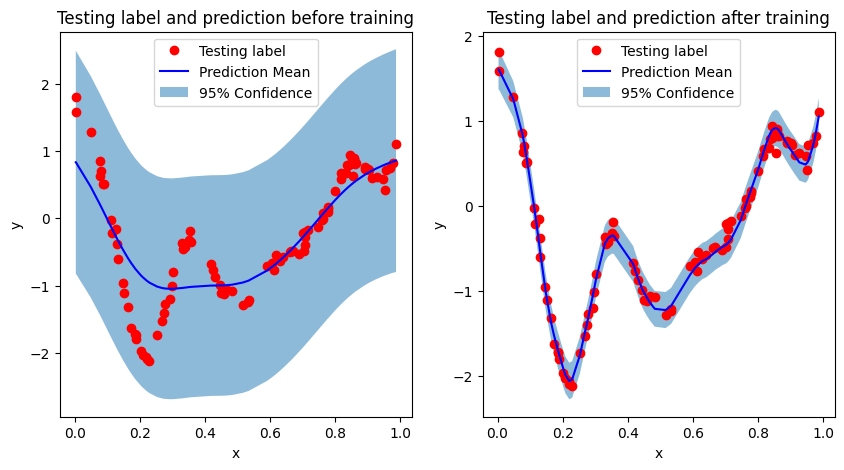

In [7]:
idx = np.argsort(test_x[0,:])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pred0_mean = Pred0.prediction_mean
pred0_stddev = Pred0.prediction_stddev
pred_mean = Pred.prediction_mean
pred_stddev = Pred.prediction_stddev

axs[0].plot(test_x[0,idx], test_y[idx], 'ro')
axs[0].plot(test_x[0,idx], pred0_mean[idx], 'b-')
axs[0].fill_between(test_x[0,idx], pred0_mean[idx] - 1.96 * pred0_stddev[idx], pred0_mean[idx] + 1.96 * pred0_stddev[idx], alpha=0.5)
axs[0].set_title('Testing label and prediction before training')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
axs[1].plot(test_x[0,idx], test_y[idx], 'ro')
axs[1].plot(test_x[0,idx], pred_mean[idx], 'b-')
axs[1].fill_between(test_x[0,idx], pred_mean[idx] - 1.96 * pred_stddev[idx], pred_mean[idx] + 1.96 * pred_stddev[idx], alpha=0.5)
axs[1].set_title('Testing label and prediction after training')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
plt.show()
plt.close(fig)